# Dano's Multi-Subject Riemann  notebook

In this notebook, I will try and use pyRiemann and data from all subjects to predict cognitive performance from EEG data in Neurodoro

In [584]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.linear_model import LinearRegression
from os import walk
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from tpot import TPOTRegressor
from math import sqrt
import pyriemann
from mne import create_info, concatenate_raws
from mne.io import RawArray
from mne.channels import read_montage
from glob import glob
from pyriemann.utils.viz import plt, plot_confusion_matrix, plot_embedding
from pyriemann.estimation import Covariances, HankelCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.clustering import Potato

Steps

1. Concat all raw datasets together
2. Use Knearest Neighbors in pipeline

In [613]:
# Here are the good raw datasets

a = pd.read_csv("../../muse-data/Dano-08-11-RawEEG3.csv", header=0, index_col=False)
b = pd.read_csv("../../muse-data/Dano-08-11-RawEEG0.csv", header=0, index_col=False)
c = pd.read_csv("../../muse-data/josh_sep_21RawEEG2.csv", header=0, index_col=False)
d = pd.read_csv("../../muse-data/josh_sep_21_distracted_RawEEG0.csv", header=0, index_col=False)
e = pd.read_csv("../../muse-data/josh-raw-aug11RawEEG2.csv", header=0, index_col=False)

In [632]:
# Add them all together

data = [a,b,c,d,e]
data = pd.concat(data, ignore_index=True)
data = data[data.Difficulty > -200]
data = data[data.Difficulty != 0]
data.clip(lower=1)
data = data.drop('Timestamp (ms)', axis = 1)
data = data.reset_index(drop=True)

In [548]:
# Using this fancy slope label doesn't help anything....

# Creating different labels. Rather than using the difficulty of the current
# timestep as labels, use the slop over the following 10 seconds.
# Rationale; Performance at point t is a result of actions over 
# some previous time period

Difficulty_Slope = [] # in points per second [10, -10]
# slope_classes 
# 2: steep up, 1:shallow up, 0: flat, -1: shallow down, -2: steep down


for i in range(len(data)):
    # 256 samples/sec * 10 seconds in the future; may need to be adjusted
    if i < len(data)-1026:
        j = i + 1025
    else: 
        j = len(data)-1
        
    slope = (data.Difficulty[j] - data.Difficulty[i]) / ((j - i +1)/256)
    Difficulty_Slope.append(slope)

    if i % 50000 == 0:
        print("Slope at sample %s is %r" % (i, slope))

data['Difficulty_Slope'] = Difficulty_Slope

# rearrange columns, remove Difficulty & Performance
data = data[['Difficulty_Slope', 'Channel 1', 'Channel 2', 'Channel 3', 'Channel 4']]

Slope at sample 0 is 4.7407407407407405
Slope at sample 50000 is -2.4951267056530213
Slope at sample 100000 is 2.7446393762183234


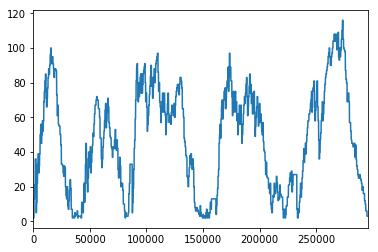

In [633]:
%matplotlib inline
data.Difficulty.plot()

In [635]:
sfreq = 256

# name of each channels 
ch_names = ['Difficulty', 'TP9', 'FP1', 'FP2', 'TP10']

# type of each channels
ch_types = ['stim'] + ['eeg'] * 4
montage = read_montage('standard_1005')

# get data and exclude Aux channel
data = data.values[:,-5:].T
data

# convert in Volts (from uVolts)
#data[:-1] *= 1e-6

# create mne objects
info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq, montage=montage)
raw = (RawArray(data=data, info=info))

# Setting up band-pass filter from 2 - 50 Hz
raw.filter(2, 50, method='iir')

AttributeError: 'numpy.ndarray' object has no attribute 'values'

tmax defaults to 60. in 0.14 but will change to np.inf in 0.15. Set it explicitly to avoid this warning
Effective window size : 8.000 (s)


<ipython-input-636-39b392d59ea0>:3: DeprecationWarning: tmax defaults to 60. in 0.14 but will change to np.inf in 0.15. Set it explicitly to avoid this warning
  raw.plot_psd(picks=[1]);
/Users/joshharris/anaconda3/lib/python3.6/site-packages/mne/viz/raw.py:614: DeprecationWarning: In version 0.15 average will default to False and spatial_colors will default to True.
  'spatial_colors will default to True.', DeprecationWarning)


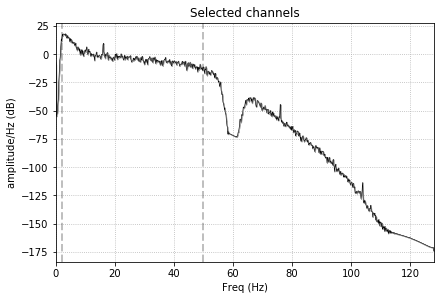

In [636]:
## Plot the PSD of the EEG data just to make sure it looks alright

raw.plot_psd(picks=[1]);


## Epochs

In [637]:
from mne import make_fixed_length_events, Epochs

# Make an events array with epoch times every .5 seconds
event = make_fixed_length_events(raw, 1, duration=0.5)

# Make an epochs array object from the raw dataset with events array event, length of 2 seconds
epochs = Epochs(raw, event, tmin=0, tmax=4, preload=True)

epochs

2312 matching events found
0 projection items activated
Loading data for 2312 events and 1025 original time points ...
7 bad epochs dropped


<Epochs  |  n_events : 2305 (all good), tmin : 0.0 (s), tmax : 4.0 (s), baseline : (None, 0), ~90.1 MB, data loaded>

In [638]:
def difficulty_class(row):
    if row <= 60:
        return 'focused'
    else:
        return 'distracted'



X = epochs.copy().pick_types(eeg=True).get_data()

y = epochs.copy().pick_types(eeg=False, stim=True).get_data().mean(axis=2)
#y = np.apply_along_axis(difficulty_class, 1, y)
print(X.shape, y.shape)

(2305, 4, 1025) (2305, 1)


In [234]:
# Let's transform our data into a covariance matrix and a tangentspace
covs = Covariances(estimator='lwf').fit_transform(X)
tans = TangentSpace().fit_transform(covs)
#potato = Potato().fit_transform(covs)

In [235]:
tans[10]

array([-1.0481381 ,  0.55461548,  0.46181952, -1.38675588, -0.70102403,
        0.56508765,  0.41013572, -0.26146938,  0.61485391, -0.91051282])

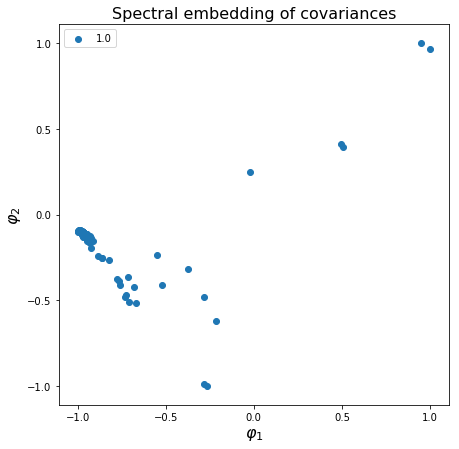

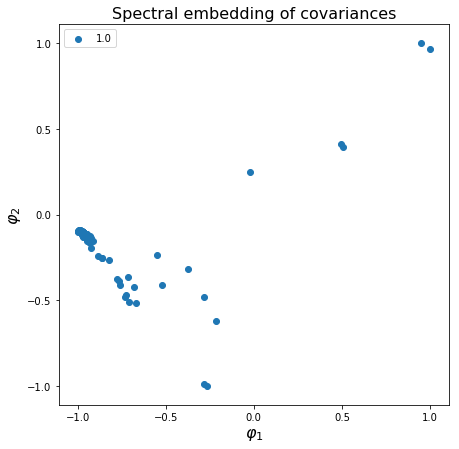

In [214]:
# Now that we have our data setup for sklearn in X and y, let's visualize it

plot_embedding(covs[::3])

In [639]:
# KNeighbors hyperparameters from TPOT
clf = make_pipeline(Covariances(), TangentSpace(), KNeighborsRegressor(n_neighbors=52, p=1, weights="distance"))

clf.fit(X, y)

Pipeline(steps=[('covariances', Covariances(estimator='scm')), ('tangentspace', TangentSpace(metric='riemann', tsupdate=False)), ('kneighborsregressor', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=52, p=1,
          weights='distance'))])

13.061712843242425


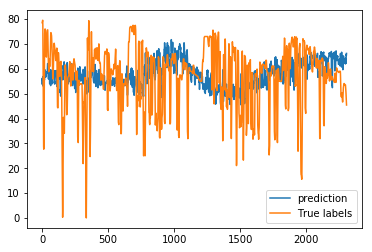

In [640]:
from sklearn.model_selection import cross_val_score, cross_val_predict

pr = cross_val_predict(clf, X, y, cv=6)

plt.plot(pr)
plt.plot(y)
plt.legend(['prediction', 'True labels'])

print(sqrt(sk.metrics.mean_squared_error(y, pr)))

# For evaluating a classifier
#accuracy = sum(pr == y) / len(pr)
#precision = sk.metrics.precision_score(y, pr, average='macro')
#recall = sk.metrics.recall_score(y, pr, average='macro')
#print("Accuracy: %s" % (accuracy))
#print("Precision: %s" % (precision))
#print("Recall: %s" % (recall))




Mean Squared error with linear regressor = 16.11
Mean Squared error with KNeighboursRegressor = 15.45
